In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes
from pymfr.reconstruct import reconstruct_map


In [2]:
torch.cuda.device_count()

1

In [3]:
time = ['2016-01-01T00:00:00Z', '2016-02-01T00:00:00Z']
file_name = f"./data/wind_{time[0]}_{time[1]}_1min_nonlin.npz".replace(':', '-')
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_nonlin',
                                               'Proton_VY_nonlin',
                                               'Proton_VZ_nonlin',
                                               'Proton_Np_nonlin',
                                               'Proton_W_nonlin'],
                                 time[0], time[1])

    datetime = data.Epoch.values

    velocity = np.column_stack([data.Proton_VX_nonlin.values,
                                data.Proton_VY_nonlin.values,
                                data.Proton_VZ_nonlin.values])
    velocity[np.any(velocity == data.Proton_VX_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_nonlin.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_nonlin.values
    density[density == data.Proton_Np_nonlin.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    temperature = data.Proton_W_nonlin.values
    temperature[temperature == data.Proton_W_nonlin.FILLVAL] = np.nan
    temperature = (temperature * 1e3) ** 2 * scipy.constants.m_p / (2 * scipy.constants.Boltzmann) / 1e6
    temperature = pd.Series(temperature, index=pd.DatetimeIndex(datetime)).interpolate()
    temperature = temperature.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = data.Epoch.values
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    temperature = temperature.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, temperature=temperature, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
temperature = torch.as_tensor(data["temperature"], dtype=torch.float32)
times = data["times"]

In [4]:
temperature * 1e6

tensor([32439.9590, 32963.4922, 33487.0234,  ..., 22718.9668, 23036.6270,
        23354.2891])

In [5]:
window_lengths = np.unique(np.geomspace(10, 24 * 60, 200).astype(int))

gas_pressure = scipy.constants.Boltzmann * (density * 1e6) * (temperature * 1e6) * 1e9

results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size=10000,
                            window_steps=[1] * len(window_lengths),
                            window_lengths=window_lengths,
                            sample_spacing=60,
                            n_trial_axes=256,
                            threshold_diff=0.3,
                            threshold_fit=0.3,
                            max_processing_resolution=32)



100%|██████████| 174/174 [00:12<00:00, 13.73it/s]


In [6]:
len(results.event)

246

2016-01-31T21:54:30.000000000  to  2016-01-31T23:24:30.000000000
window length: 90
duration: 90.0
error: 0.223 0.211
walen slope: -0.017
mach number: 0.076
alfvenicity: -0.016
<B>: 10.11
Altitude/azimuth: 154 / 116
Frame quality: 0.999955952167511
Field alignment -0.21720050275325775


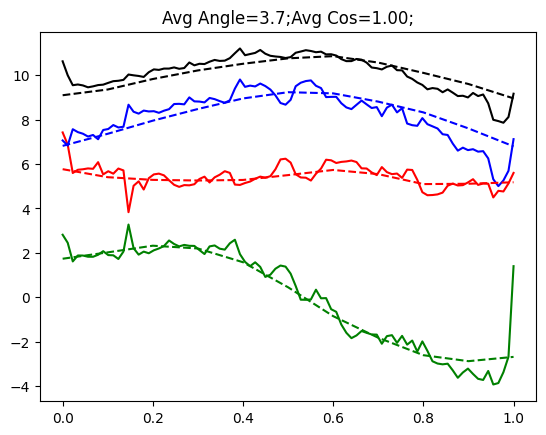

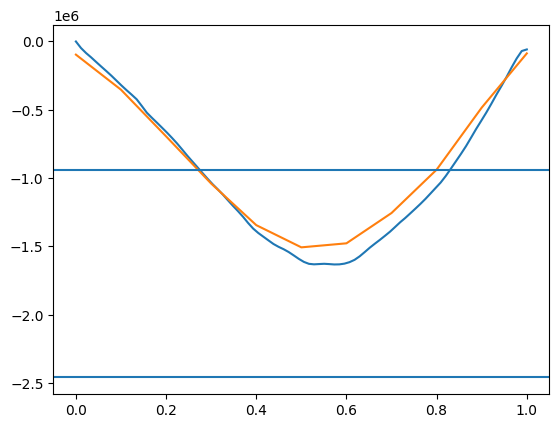

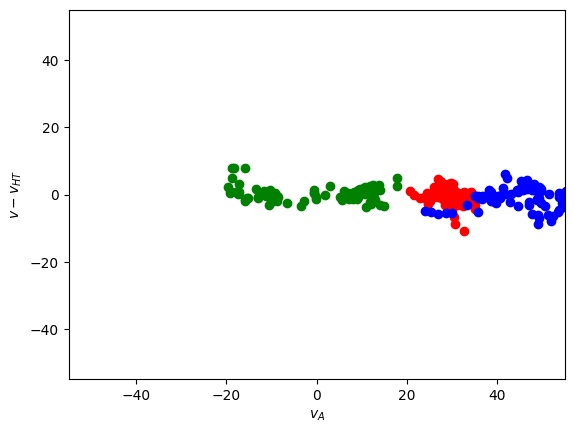

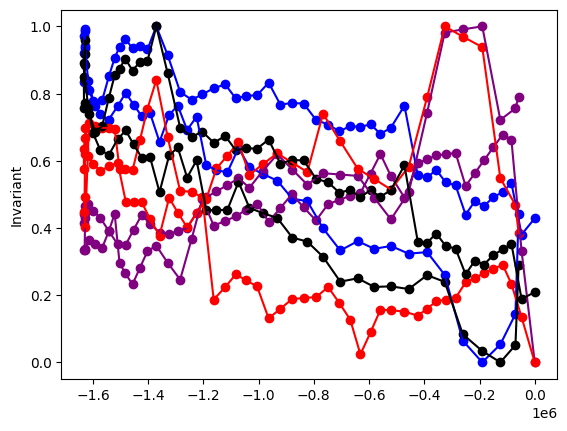

closed % 33
width 0.6
height 0.3333333333333333
poloidal flux per au 228286.0125
axial flux 125.39726233600001
twist per au 1820.5023638260236
field line length 0.000549298929718701
<xarray.DataArray 'spatial_scale' ()>
array(0.0108513)
scale in au 0.0007625518357035185


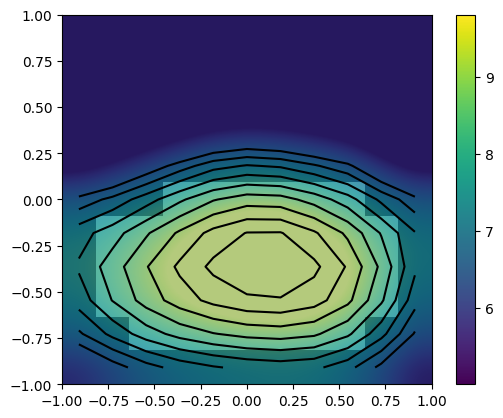

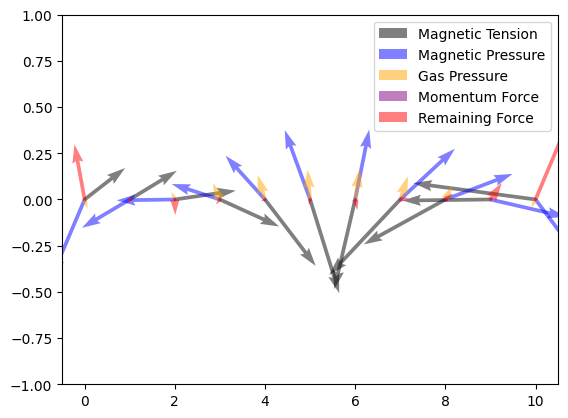

2016-01-31T19:53:30.000000000  to  2016-01-31T20:46:30.000000000
window length: 53
duration: 53.0
error: 0.25 0.176
walen slope: -0.431
mach number: 0.437
alfvenicity: -0.432
<B>: 9.44
Altitude/azimuth: 144 / 344
Frame quality: 0.9997140169143677
Field alignment -0.965148389339447


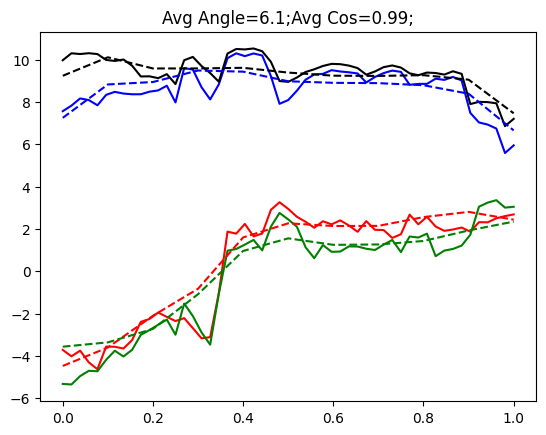

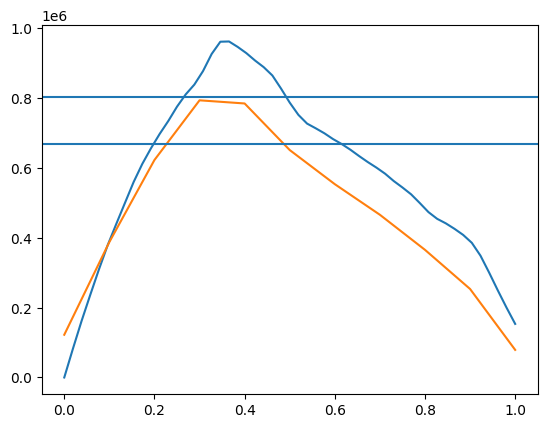

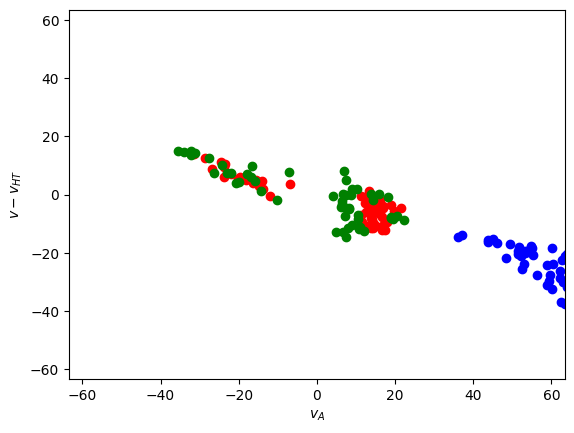

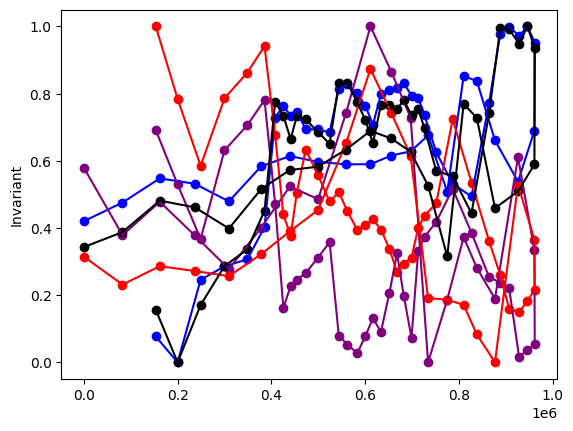

closed % 9
width 0.4666666666666667
height 0.3333333333333333
poloidal flux per au 20263.846875000003
axial flux 26.366550016
twist per au 768.543736768872
field line length 0.0013011621228015224
<xarray.DataArray 'spatial_scale' ()>
array(0.00545165)
scale in au 0.0003563222620386137


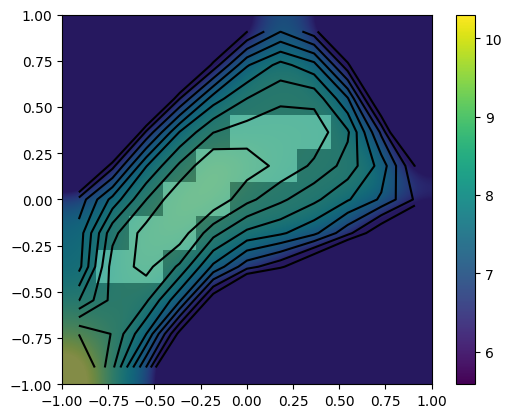

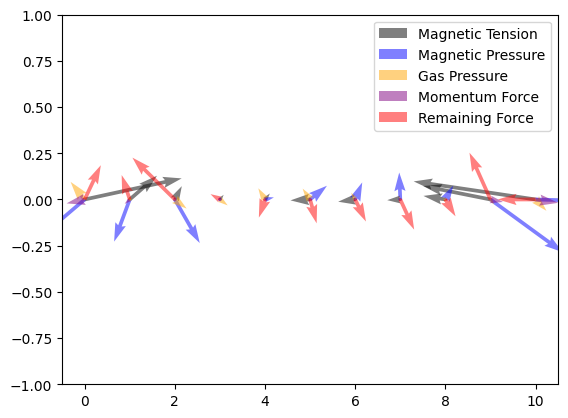

2016-01-31T14:32:30.000000000  to  2016-01-31T14:49:30.000000000
window length: 17
duration: 17.0
error: 0.274 0.208
walen slope: 0.168
mach number: 0.203
alfvenicity: 0.168
<B>: 7.81
Altitude/azimuth: 159 / 58
Frame quality: 0.999781608581543
Field alignment 0.8049404621124268


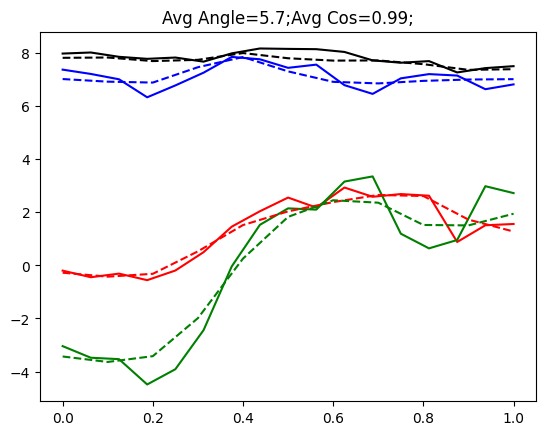

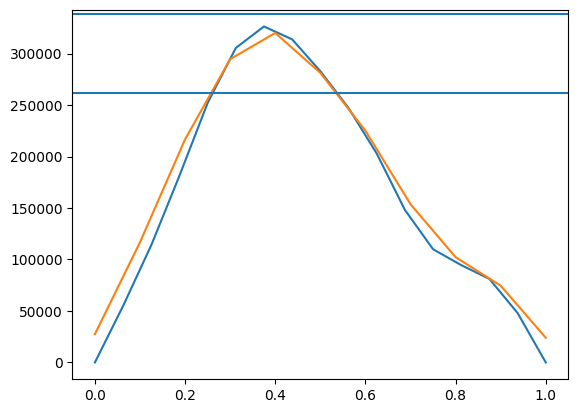

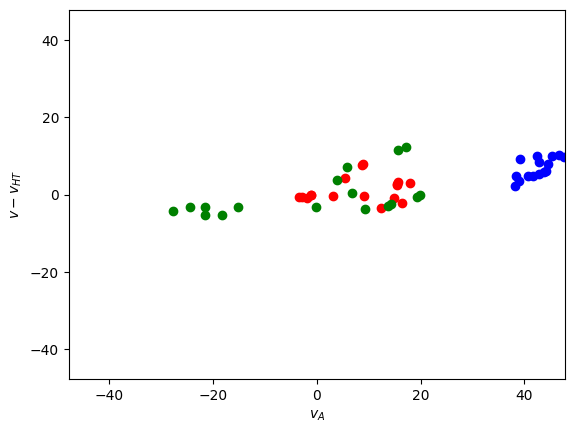

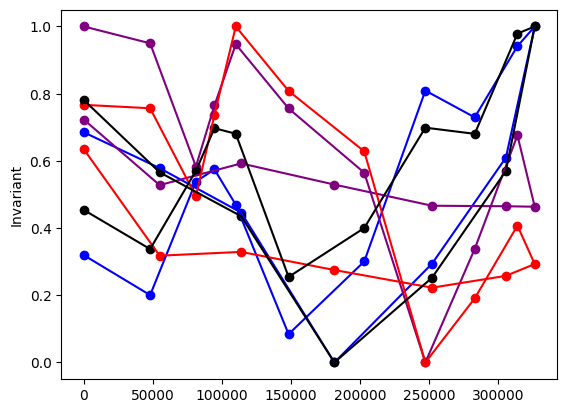

closed % 10
width 0.3333333333333333
height 0.3333333333333333
poloidal flux per au 11599.1625
axial flux 27.581280256000003
twist per au 420.54474601398283
field line length 0.0023778682517811094
<xarray.DataArray 'spatial_scale' ()>
array(0.00190765)
scale in au 0.00040459580083880255


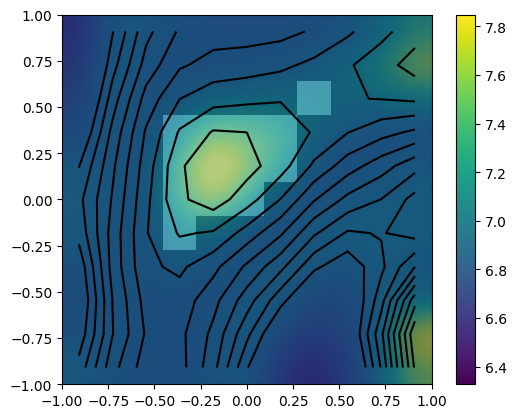

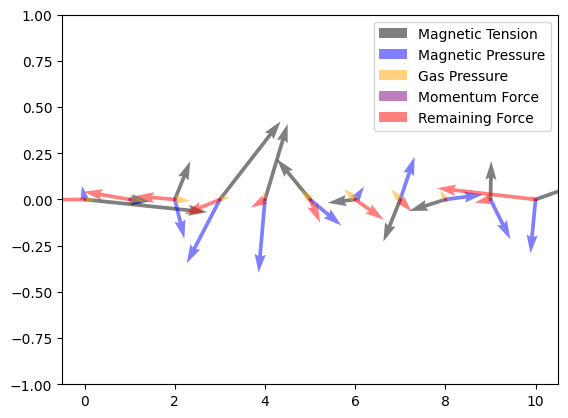

2016-01-31T12:11:30.000000000  to  2016-01-31T13:45:30.000000000
window length: 94
duration: 94.0
error: 0.254 0.233
walen slope: 0.455
mach number: 0.51
alfvenicity: 0.459
<B>: 6.44
Altitude/azimuth: 121 / 14
Frame quality: 0.9996816515922546
Field alignment 0.913330078125


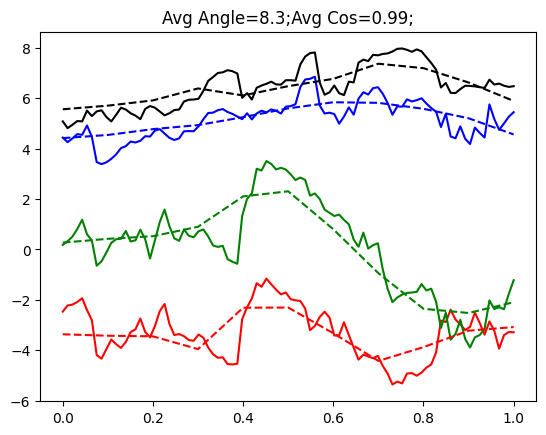

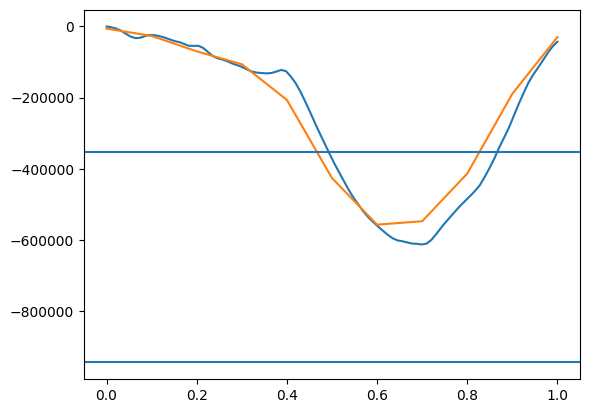

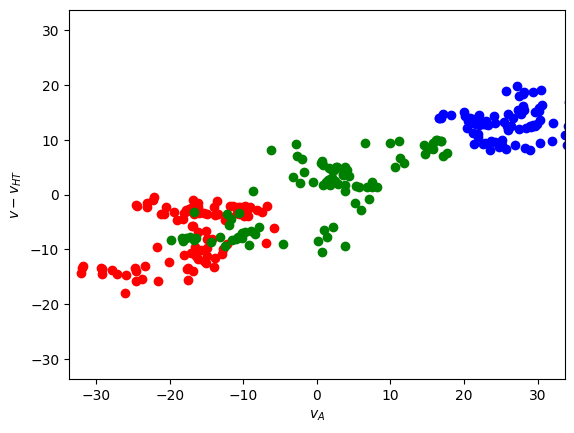

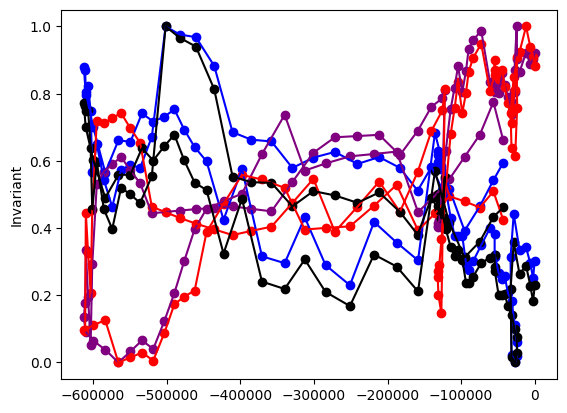

closed % 15
width 0.3333333333333333
height 0.3333333333333333
poloidal flux per au 88537.49062499999
axial flux 9.510112256000001
twist per au 9309.826029565636
field line length 0.00010741339277707818
<xarray.DataArray 'spatial_scale' ()>
array(0.00557599)
scale in au 0.00025856558070528913


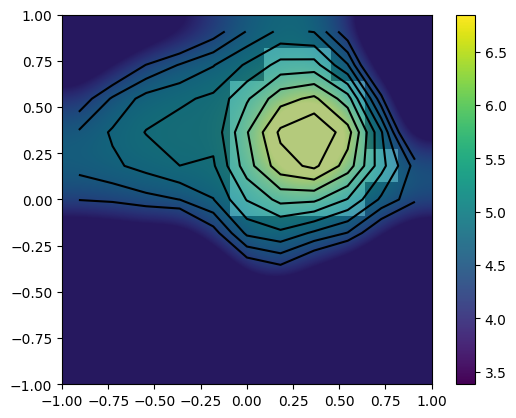

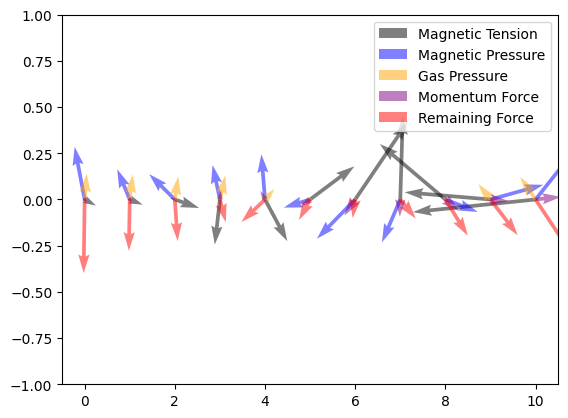

2016-01-31T06:27:30.000000000  to  2016-01-31T06:59:30.000000000
window length: 32
duration: 32.0
error: 0.283 0.206
walen slope: 0.094
mach number: 0.146
alfvenicity: 0.094
<B>: 6.89
Altitude/azimuth: 151 / 63
Frame quality: 0.999875009059906
Field alignment 0.6236081719398499


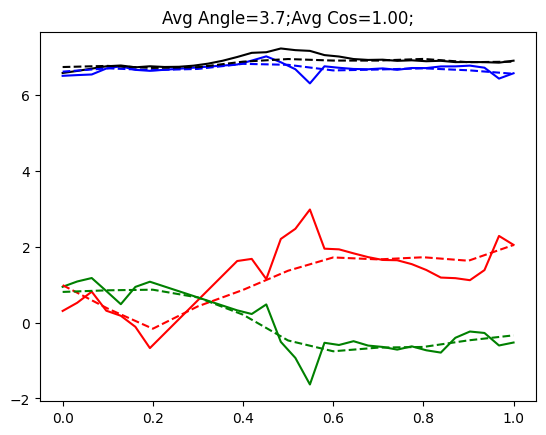

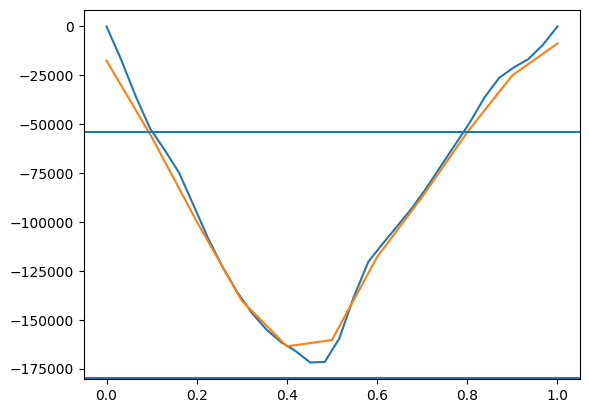

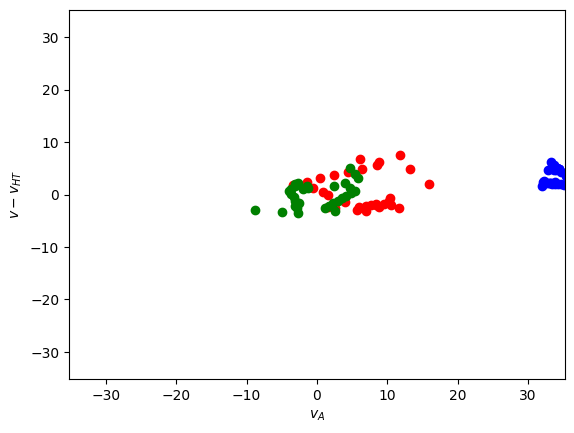

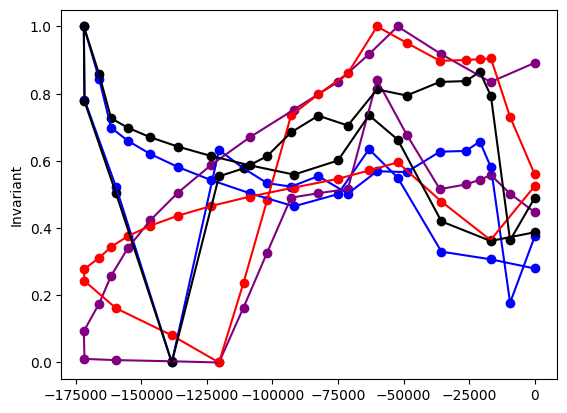

closed % 28
width 0.6
height 0.4
poloidal flux per au 18891.994921875
axial flux 64.88987648
twist per au 291.13932629688065
field line length 0.0034347815965620524
<xarray.DataArray 'spatial_scale' ()>
array(0.00354751)
scale in au 0.000655854640431058


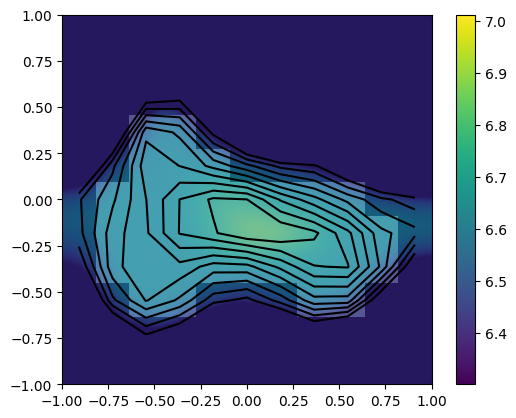

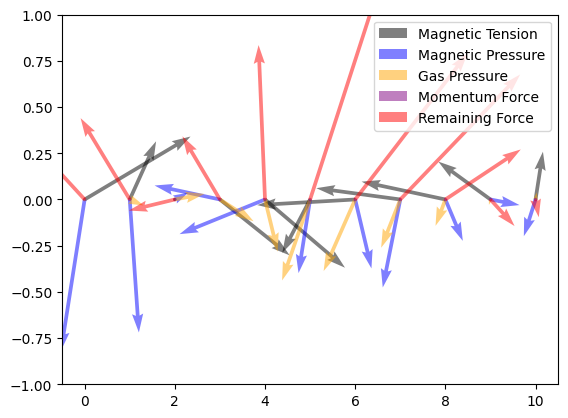

In [7]:
from scipy.stats import pearsonr

def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for i_event in list(sorted(results.event, reverse=True, key=lambda x: results.window_start.sel(event=x)))[:5]:
    event = results.sel(event=i_event)
    axis = event[["axis_x", "axis_y", "axis_z"]].to_array().values
    propagation_velocity = event[["velocity_x", "velocity_y", "velocity_z"]].to_array().values
    window_start = event.window_start.item()
    window_length = event.window_length.item()
    temporal_scale = event.temporal_scale.item()
    residue = event.residue_diff.item()
    error_fit = event.residue_fit.item()

    event_flow_velocity = velocity[window_start:window_start + window_length].cpu().numpy()
    event_magnetic_field = magnetic_field[window_start:window_start + window_length].cpu().numpy()
    event_density = density[window_start:window_start + window_length].cpu().numpy()
    Pgas = gas_pressure[window_start:window_start + window_length].cpu().numpy()

    x_unit = -(propagation_velocity - np.dot(propagation_velocity, axis) * axis)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(axis, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, axis])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix
 
    rotated = rotation_matrix @ event_magnetic_field.T
 
    alfven_velocity = event_magnetic_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    remaining_flow = event_flow_velocity - propagation_velocity

    d_flow = remaining_flow
    d_alfven = alfven_velocity
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()
    mach_number = (np.linalg.norm(remaining_flow, axis=1) / np.linalg.norm(alfven_velocity, axis=1)).mean()


    dx = np.linalg.norm(np.dot(propagation_velocity, x_unit)) * 60
    A = scipy.integrate.cumulative_trapezoid(-rotated[1], initial=0, dx=dx)
    alpha = event.walen_slope.item() ** 2
    Pt = Pgas / (1 - alpha) + ((rotated[2] * 1e-9) ** 2 + (alpha / (1 - alpha)) * (np.linalg.norm(rotated, axis=0)* 1e-9) ** 2) / (2 * 1.25663706212e-6) * 1e9

    colors = ["red", "green", "blue"]

    A_peak = A[np.abs(A).argmax()]
    A_sign = np.sign(A_peak)

    map_core_mask = event.map_core_mask.values
    map_A = event.map_Az.values
    
    closed_min = (map_A[map_core_mask] * A_sign).min()
    closed_max = (map_A[map_core_mask] * A_sign).max()

    alfven_velocity = alfven_velocity @ rotation_matrix.T
    remaining_flow = remaining_flow @ rotation_matrix.T

    # indices = np.flatnonzero(event.map_Az * A_sign > 0)

    # plt.axvline(event.map_Az.values.reshape(-1)[(np.where(event.map_core_mask, event.map_Jz.values, 0) * A_sign).argmax()])
    # plt.scatter(event.map_Az.values.reshape(-1)[indices], event.map_Jz.values.reshape(-1)[indices])
    # plt.show()
    # continue
    

    # if walen_slope > 0.3:
    #     continue

    print(times[window_start], " to ", times[window_start + window_length])
    print("window length:", window_length)
    print("duration:", temporal_scale / 60)
    print("error:", round(residue, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("mach number:", round(mach_number, 3))
    print("alfvenicity:", round(event.walen_slope.item(), 3))
    print("<B>:", round(np.linalg.norm(event_magnetic_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))
    print("Frame quality:", event.frame_quality.item())
    print("Field alignment", event.flow_field_alignment.item())

    for i_color, color in enumerate(colors):
        plt.plot(np.linspace(0, 1, len(rotated[i_color])), rotated[i_color], color=color)
    plt.plot(np.linspace(0, 1, len(rotated[0])), np.linalg.norm(rotated, axis=0), color="black")

    resolution = map_A.shape[-1]

    plt.plot(np.linspace(0, 1, resolution), event.map_Bx[event.map_Bx.shape[0] // 2, :], color="red", ls="--")
    plt.plot(np.linspace(0, 1, resolution), event.map_By[event.map_By.shape[0] // 2, :], color="green", ls="--")
    plt.plot(np.linspace(0, 1, resolution), event.map_Bz[event.map_Bz.shape[0] // 2, :], color="blue", ls="--")
    plt.plot(np.linspace(0, 1, resolution), np.sqrt(event.map_Bx[resolution // 2, :] ** 2 + event.map_By[resolution // 2, :] ** 2 + event.map_Bz[resolution // 2, :] ** 2), color="black", ls="--")

    interpolated_reconstruction = np.column_stack([np.interp(np.linspace(0, 1, window_length),
                                            np.linspace(0, 1, resolution),
                                            x[x.shape[0] // 2, :])
                                            for x in [event.map_Bx, event.map_By, event.map_Bz]])
    rotated_normalized = (rotated.T / np.linalg.norm(rotated.T, axis=1, keepdims=True))
    reconstruction_normalized = (interpolated_reconstruction / np.linalg.norm(interpolated_reconstruction, axis=1, keepdims=True))
    deviation = ((interpolated_reconstruction - rotated.T)) / np.linalg.norm(rotated, axis=0)[:, None]
    plt.title(f"Avg Angle={np.rad2deg(np.arccos((rotated_normalized * reconstruction_normalized).sum(axis=1))).mean():.1f};" +\
              f"Avg Cos={(rotated_normalized * reconstruction_normalized).sum(axis=1).mean():0.2f};")
    
    
    plt.show()

    plt.plot(np.linspace(0, 1, len(A)), A)
    plt.plot(np.linspace(0, 1, resolution), map_A[map_A.shape[0] // 2, :])
    plt.axhline(closed_min * A_sign)
    plt.axhline(closed_max * A_sign)
    plt.show()

    for i, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i], remaining_flow[:, i], color=color)
        plt.xlabel(r"$v_A$")
        plt.ylabel(r"$v - v_{HT}$")
    
    avg_alfven_speed = np.linalg.norm(alfven_velocity, axis=1).mean()
    plt.xlim(-avg_alfven_speed, avg_alfven_speed)
    plt.ylim(-avg_alfven_speed, avg_alfven_speed)
    plt.show()

    def plot_invariant(invariant, color):
        plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
        plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
    plot_invariant(rotated[2], "blue")
    plot_invariant(event_density, "purple")
    plot_invariant(Pgas, "red")
    plot_invariant(Pt, color="black")
    plt.ylabel("Invariant")
    plt.show()

    extent = (-1, 1, -1, 1)

    plt.imshow(event.map_Bz, vmin=max(0, rotated[2].min()), vmax=rotated[2].max(), interpolation="bicubic", extent=extent, origin="lower")
    # plt.imshow(map_A / A_peak, vmin=0, cmap="gist_heat", extent=extent, origin="lower")
    plt.colorbar()
    enclosed_levels = (map_A[map_core_mask] * A_sign)
    levels = np.linspace(0, enclosed_levels.max(), 10)
    plt.contour(map_A * A_sign, origin="lower", extent=extent, levels=levels, colors="black", algorithm="serial", antialiased=True)
   
    plt.xlim(extent[0], extent[1])
    plt.ylim(extent[2], extent[3])
    

    print("closed %", int(100 * map_core_mask.mean()))
    print("width", np.any(map_core_mask, axis=-2).sum() / 15)
    print("height", np.any(map_core_mask, axis=-1).sum() / 15)

    poloidal_flux = (closed_max - closed_min) * 1e-9 * 1.5e8
    axial_flux = (event.map_Bz.values[map_core_mask] * dx ** 2).sum().item() * 1e-9

    print("poloidal flux per au", poloidal_flux)
    print("axial flux", axial_flux)
    print("twist per au", poloidal_flux / axial_flux)
    print("field line length", axial_flux / poloidal_flux)
    print(event.spatial_scale / 1.5e8)
    print("scale in au", np.sqrt(np.count_nonzero(map_core_mask) * (dx / 1.5e8) ** 2))

    plt.imshow(map_core_mask, vmin=0, vmax=2, origin="lower", extent=extent, cmap="Blues_r", alpha=0.5)


    plt.show()

    map_dx = event.spatial_scale.item() / resolution
    force_tension_x = (event.map_Bx * np.gradient(event.map_Bx.values, map_dx, axis=1)\
                                    + event.map_By * np.gradient(event.map_Bx.values, map_dx, axis=0))[resolution // 2] * (1e-18 / scipy.constants.mu_0)
    force_tension_y = (event.map_Bx * np.gradient(event.map_By.values, map_dx, axis=1)\
                            + event.map_By * np.gradient(event.map_By.values, map_dx, axis=0))[resolution // 2] * (1e-18 / scipy.constants.mu_0)
    force_magnetic_pressure_x = -np.gradient((event.map_Bx ** 2 + event.map_By ** 2 + event.map_Bz ** 2).values, map_dx, axis=1)[resolution // 2] / 2 * (1e-18 / scipy.constants.mu_0)
    force_magnetic_pressure_y = -np.gradient((event.map_Bx ** 2 + event.map_By ** 2 + event.map_Bz ** 2).values, map_dx, axis=0)[resolution // 2] / 2 * (1e-18 / scipy.constants.mu_0)


    dP_dA = np.polyder(np.poly1d(np.polyfit(A, Pgas, 2)))

    force_gas_pressure_x = -(-event.map_By * dP_dA(event.map_Az) * 1e-9)[resolution // 2]
    force_gas_pressure_y = -(event.map_Bx * dP_dA(event.map_Az) * 1e-9)[resolution // 2]

    force_momentum_x = -walen_slope ** 2 * force_tension_x
    force_momentum_y = -walen_slope ** 2 * force_tension_y

    plt.ylim(-1, 1)

    scale = float(np.max(np.sqrt(force_tension_x ** 2 + force_tension_y ** 2)) * 1.5)

    plt.quiver(range(resolution), np.zeros(resolution),
                force_tension_x, force_tension_y,
                color="black", label="Magnetic Tension", angles="uv", scale=scale, scale_units="y", alpha=0.5)
    plt.quiver(range(resolution), np.zeros(resolution),
                force_magnetic_pressure_x, force_magnetic_pressure_y,
                color="blue", label="Magnetic Pressure", angles="uv", scale=scale, scale_units="y", alpha=0.5)
    plt.quiver(range(resolution), np.zeros(resolution),
                force_gas_pressure_x, force_gas_pressure_y,
                color="orange", label="Gas Pressure", angles="uv", scale=scale, scale_units="y", alpha=0.5)
    plt.quiver(range(resolution), np.zeros(resolution),
                force_momentum_x, force_momentum_y,
                color="purple", label="Momentum Force", angles="uv", scale=scale, scale_units="y", alpha=0.5)
    plt.quiver(range(resolution), np.zeros(resolution),
                -(force_tension_x + force_magnetic_pressure_x + force_momentum_x + force_gas_pressure_x),
                -(force_tension_y + force_magnetic_pressure_y + force_momentum_y + force_gas_pressure_y),
                color="red", label="Remaining Force", angles="uv", scale=scale, scale_units="y", alpha=0.5)
    plt.legend()
    plt.show()




